# Q-Learning 

**Problem Description**   
You will work towards implementing and evaluating the Q-learning algorithm on a simple domain. Q-learning is a fundamental RL algorithm and has been successfully used to solve a variety of decision-making problems. For this homework,you will have to think carefully about algorithm implementation, specially exploration parameters.   

The domain you will be tackling is called Taxi. ([Dietterich 2000](https://www.jair.org/media/639/live-639-1834-jair.pdf)). It is a discrete MDP which has been used for RL research in the past. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop them off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions. 


Implement a basic version of the Q-learning algorithm. The agent should explore the MDP, collect data to the learn the optimal policy and the optimal Q-value function. (Be mindful of how you handle terminal states, typically if $S_t$ is a terminal state, $V(S_t+1) = 0$). Use $𝛾 = 0.90$. Also, you will see how Epsilon-Greedy strategy can find the optimal policy despite of finding sub-optimal q-values. Because we are looking for optimal q-values, you will have to try different exploration strategies.

The Q-Learning Algorithm:  
$$ \text{Initialize Q} \rightarrow \text{Choose action} \rightarrow \text{Perform action} \rightarrow \text{Measure Reward} \rightarrow \text{Update Q} $$
The Q-Learning Update:  
$$ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t +1} + \gamma \, \text{max}_a \, Q(S_{t+1}, a) - Q(S_t, A_t)] $$


In [254]:
import numpy as np
import pandas as pd
import datetime as dt

In [255]:
def read_stock(path="AAPL.csv"):
    df = pd.read_csv(path)
    df.index = df.Date
    prices = df.iloc[:,-1]
    returns = pd.Series(prices.values[:-1]-prices.values[1:], index=prices.index[:-1])
    return prices, returns

def calc_stats(port_val):
    # Get portfolio statistics (note: std_daily_ret = volatility)

    dr = (port_val[1:] / port_val[:-1].values) - 1  # Ignore first day
    current_return = dr.values[-1]
    cr = (port_val[-1] / port_val[0]) - 1           # Ratio of value on last day to first day
    addr = dr.mean()
    sddr = dr.std()
    sr = calc_sharpe_ratio(dr, rfr=0.0, freq=252)             # Calculate Sharpe Ratio
    return current_return, addr, sddr, sr


def calc_sharpe_ratio(rp, rfr, freq):
    """
    Caclulate Sharpe Ratio
    :param rp: Portfolio Return Values
    :param rfr: Risk Free Return
    :param freq: Frequency Data was sampled at
    :return: sharpe ratio
    """
    # if rfr != 0:
    #     rfr = np.power((1.0 + rfr), (1.0/freq))
    s = (rp - rfr).mean()/rp.std()
    s_ann = np.sqrt(freq) * s
    return s_ann

def calc_state(date):
    sr_raw = calc_stats(prices.loc[:date])[3]
    if sr_raw > 0:
        sr = 'positive' 
    elif sr_raw < 0:
        sr = 'negative'
    else:
        sr = 'zero'
    state = (sr)
    return(state)

In [256]:
class QLearner:
    
    def __init__(self, epsilon=0.2, epsilon_decay=0.9, alpha=0.2, gamma=0.9, actions = ["BUY", "SELL", "HOLD"],window=1):
        """
            epsilon        : exploration rate
            epsilon_decay  : decay factor for epsilon
            alpha          : learning rate
            gamma          : discount factor
            env            : environment agent will be used on
        """
        self.q = {}                                                          # Q values {(state, action) -> value}
        self.policy = {}                                                     # Policy   {state -> action}
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions
        self.window = window
        
    def get_q(self, state, action):
        """
            Retrieve Q-Value for a <state,action> pair
        """
        sa_pair = (state, action)
        if not sa_pair in self.q:                                             # New State, initialize Q-value to 0
            self.q[sa_pair] = 0
        return self.q[sa_pair]

    
    def get_action(self, s):
        """
            Given a state, return action to be taken
            Uses epsilon-greedy approach to balance exploration-exploitation
            Action:
              argmax_a Q(a)      with probability 1−ε
              random action      with probability ε
        """
        if not s in self.policy:                                              # Initialize randomly
            self.policy[s] = self.actions[np.random.randint(0, len(self.actions))]
            
        if np.random.random() <= self.epsilon:                                # Take random action
            self.epsilon = self.epsilon * self.epsilon_decay                  # Decay epsilon
            return self.actions[np.random.randint(0, len(self.actions))]
        else:                                                                 # Take optimal action
            return self.policy[s]
             
        
    def update(self, s_t, a, s_tp1, r):
        """
            Perform Q-Learning update, update optimal policy
        """
        q_s_a = self.get_q(s_t, a)                                            # Immediate Reward
        
        future_q = [self.get_q(s_tp1, a) for a in self.actions]               # Q-Values for S_t+1
        disc_future_r = self.gamma * max(future_q)                            # Discounted Future Reward
        
        self.q[(s_t, a)] = q_s_a + self.alpha * (r + disc_future_r - q_s_a)   # Update Q-Value for S_t
        
        q_vals = [self.get_q(s_t, a) for a in self.actions]                   # Update policy
        self.policy[s_t] = self.actions[q_vals.index(max(q_vals))]            # Argmax, best action for S_t


    def train(self, num_episodes):
        """
            Train the Q-Learning agent across multiple episodes 
        """
        
        window=self.window
        self.cum_reward = [0]*num_episodes
        self.ch_actions = {}
        for itr, ep in enumerate(range(num_episodes)):
            if ep % 1 == 0:
                print("Episode {}".format(ep))
        
            for i in range(1,len(prices.index)-window):
                state = calc_state(prices.index[i])
                date = prices.index[i]
                action = self.get_action(state)                               # Choose action
                next_state = calc_state(prices.index[i+window])                    # Perform action, record reward and next state
                
                self.ch_actions[date] = action
                
                if action == 'BUY':
                    reward = calc_stats(prices.iloc[:i+window])[0]
                elif action == 'SELL':
                    reward = calc_stats(prices.iloc[:i+window])[0]*(-1)
                else:
                    reward = 0
                
                self.cum_reward[itr]+=reward
                self.update(state, action, next_state, reward)          # Update Q
        print("\n")
        self.ac_df = pd.DataFrame(self.ch_actions,index=[0])

  Evaluate your agent using the OpenAI gym environment and use it to solve the taxi domain.

In [257]:
prices, returns = read_stock("AAPL.csv")

In [258]:
agent = QLearner(epsilon=0.25, epsilon_decay=1.0, alpha=0.8, gamma=0.9,window=1)
agent.train(num_episodes=10)         

Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9




In [259]:
agent.q

{('zero', 'BUY'): 0.058550038021757005,
 ('negative', 'BUY'): 0.015299118070456096,
 ('negative', 'SELL'): 0.09386255573337703,
 ('negative', 'HOLD'): 0.015339939378001252,
 ('zero', 'SELL'): 0.05041419377733014,
 ('zero', 'HOLD'): 0.020289423353279594,
 ('positive', 'BUY'): 0.03603040035721024,
 ('positive', 'SELL'): 0.02721230565897379,
 ('positive', 'HOLD'): 0.037303797893240224}

In [260]:
agent.policy

{'zero': 'BUY', 'negative': 'SELL', 'positive': 'HOLD'}

In [261]:
agent.cum_reward

[-1.364891376889746,
 0.2813910940411901,
 2.7281150589710736,
 -0.14396883183689102,
 0.10441249824385868,
 -1.744144798818894,
 0.12070129893746462,
 -0.6393623309791342,
 -0.2024468558939927,
 -0.5079981052353851]

In [262]:
import matplotlib.pyplot as plt
decisions = agent.ac_df.transpose().replace('BUY',1).replace('SELL',-1).replace('HOLD',0).astype('int').sort_index().cumsum()
decisions

,0
2000-02-02,-1
2000-02-03,0
2000-02-04,-1
2000-02-07,-2
2000-02-08,-3
...,...
2012-09-05,-180
2012-09-06,-180
2012-09-07,-180
2012-09-10,-180


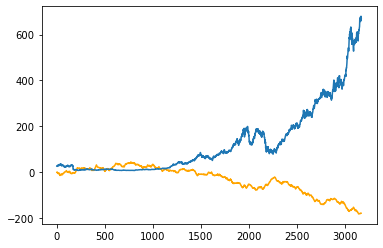

In [263]:
plt.plot(decisions.values[:,0],c='orange')
plt.plot(prices.sort_index().values)
plt.show()

In [264]:
agent.ac_df.transpose().iloc[:,0].value_counts()

HOLD    1387
SELL     983
BUY      803
Name: 0, dtype: int64

In [265]:
prices.sort_index()

Date
2000-02-01     24.96
2000-02-02     24.60
2000-02-03     25.72
2000-02-04     26.88
2000-02-07     28.39
               ...  
2012-09-06    676.27
2012-09-07    680.44
2012-09-10    662.74
2012-09-11    660.59
2012-09-12    669.79
Name: Adj Close, Length: 3175, dtype: float64